In [1]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

In [2]:
cmap = 'tab20'

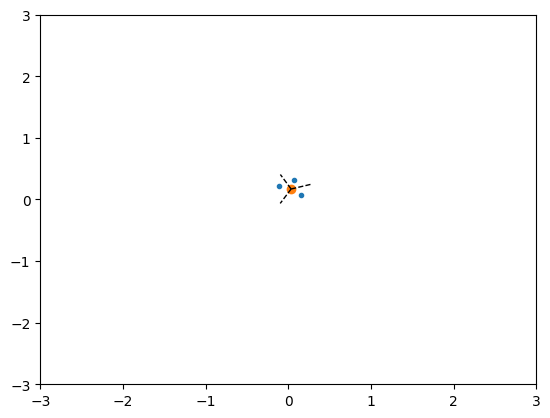

In [3]:
from scipy.spatial import Voronoi, voronoi_plot_2d
np.random.seed(0)
num_cells = 3
cell_labels = np.arange(num_cells) + 1
vornoi_points = np.random.uniform(-.75,.75,(num_cells,2))
vor = Voronoi(vornoi_points)
voronoi_plot_2d(vor)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

In [4]:
def find_label(x,y):
    if (x**2 + y**2) > 4:
        return 0
    #if np.abs(x) > 2 or np.abs(y) > 2:
        # return 0
    index = np.argmin((vornoi_points[:,0]-np.asarray(x))**2 + (vornoi_points[:,1]-np.asarray(y))**2)
    return cell_labels[index]

In [5]:
def data_fn(x,y):
    out = []
    # print(x.shape)
    x_flat, y_flat = x.flatten(), y.flatten()
    for x_i, y_i in zip(x_flat, y_flat):
        label = find_label(x_i, y_i)
        out.append(label)
    out = np.asarray(out).reshape(x.shape)
    # print(out.shape)

    return torch.tensor(out)

In [6]:
def gen_data(num_data, seed = 2019):
    torch.random.manual_seed(seed)

    x = np.random.uniform(-3,3,(num_data,1)).astype(np.float32)
    y = np.random.uniform(-3,3,(num_data,1)).astype(np.float32)
    # round to nearest .06
    x = np.round(x/.06)*.06
    y = np.round(y/.06)*.06

    z = data_fn(x, y)
    return torch.cat((torch.tensor(x),torch.tensor(y)),dim=1), z, data_fn

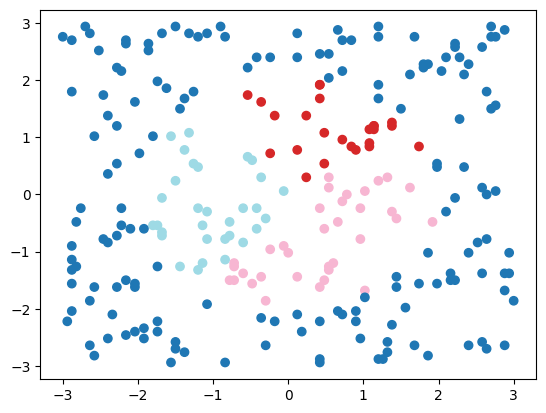

In [7]:
train_x, train_y, genfn = gen_data(250)
plt.scatter(train_x[:,0], train_x[:,1], c=train_y, cmap=cmap)

In [8]:
test_grid_size = 100
test_d1 = np.linspace(-3, 3, test_grid_size, dtype=np.float32)
test_d2 = np.linspace(-3, 3, test_grid_size, dtype=np.float32)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)), dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_y = test_labels.view(-1)

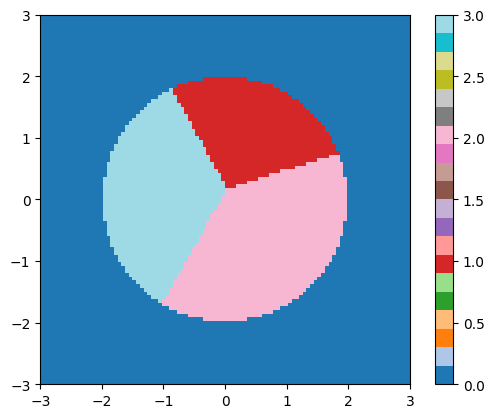

In [9]:
plt.imshow(test_labels, cmap=cmap, origin='lower', extent=[-3,3,-3,3])
plt.colorbar()


In [10]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [11]:
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            grid_size=100, num_dims=2, grid_bounds=((-3, 3), (-3, 3)),
        )
        # self.covar_module = gpytorch.kernels.GridInterpolationKernel(
        #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(
        #     batch_shape=torch.Size((num_classes,))
        #     )),
        #     grid_size=100, num_dims=2,
        # )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y.flatten(), learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [12]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #     i + 1, training_iter, loss.item(),
        # ))
        print(f'Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}')
    optimizer.step()

Iter 1/50 - Loss: 10.607
Iter 6/50 - Loss: 9.391
Iter 11/50 - Loss: 8.916
Iter 16/50 - Loss: 8.759
Iter 21/50 - Loss: 8.673
Iter 26/50 - Loss: 8.576
Iter 31/50 - Loss: 8.467
Iter 36/50 - Loss: 8.358
Iter 41/50 - Loss: 8.254
Iter 46/50 - Loss: 8.157


In [13]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(100):
    test_dist = model(test_x)

    pred_means = test_dist.loc
    pred_cov = likelihood(test_dist).stddev

In [14]:
pred_cov.shape

torch.Size([4, 10000])

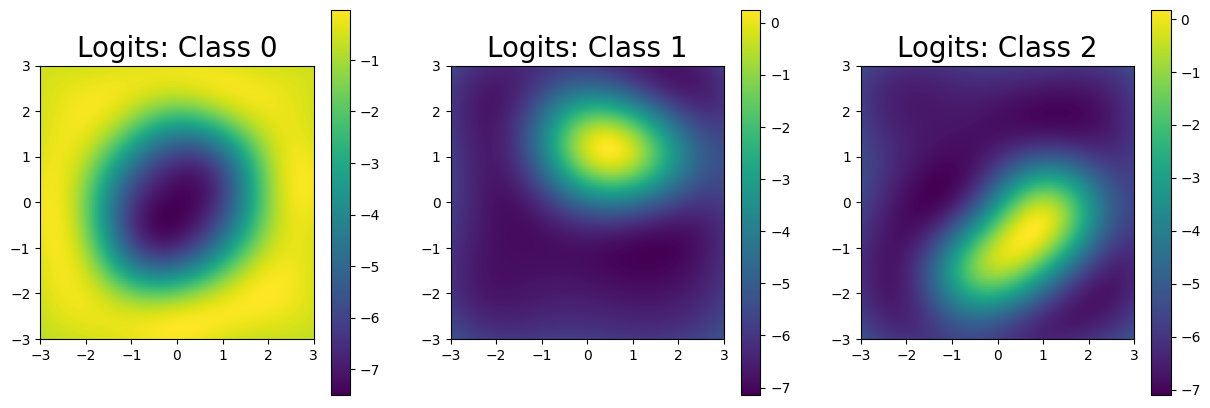

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    # im = ax[i].contourf(
    #     test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((20,20))
    # )
    im = ax[i].imshow(pred_means[i].numpy().reshape(test_grid_size,test_grid_size), origin='lower', extent=[-3,3,-3,3])
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)


/Users/matthewstaab/Documents/ALS_Fellowship/gpytorch_test/venv/lib/python3.9/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():


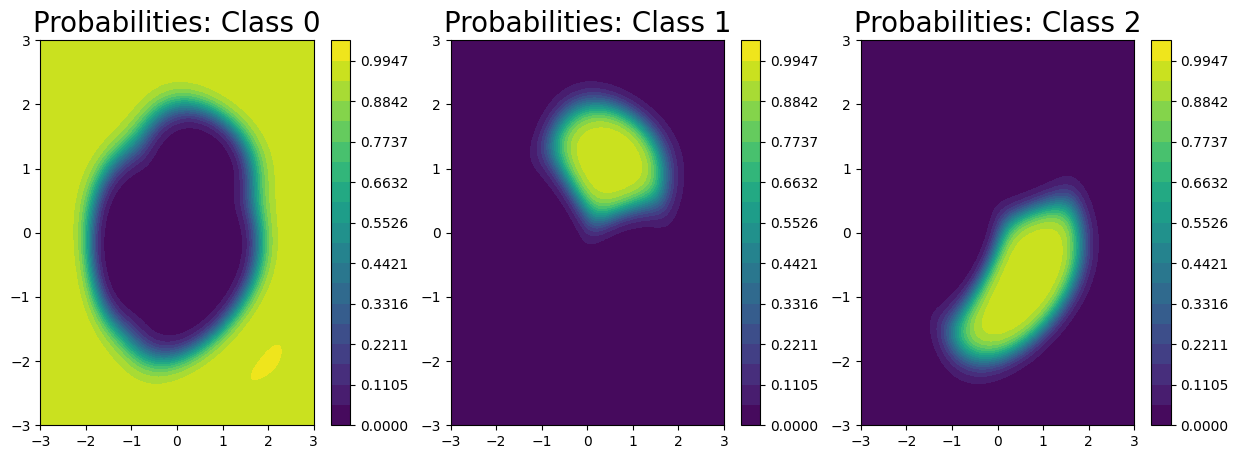

In [16]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((test_grid_size,test_grid_size)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

Error: 5.53%


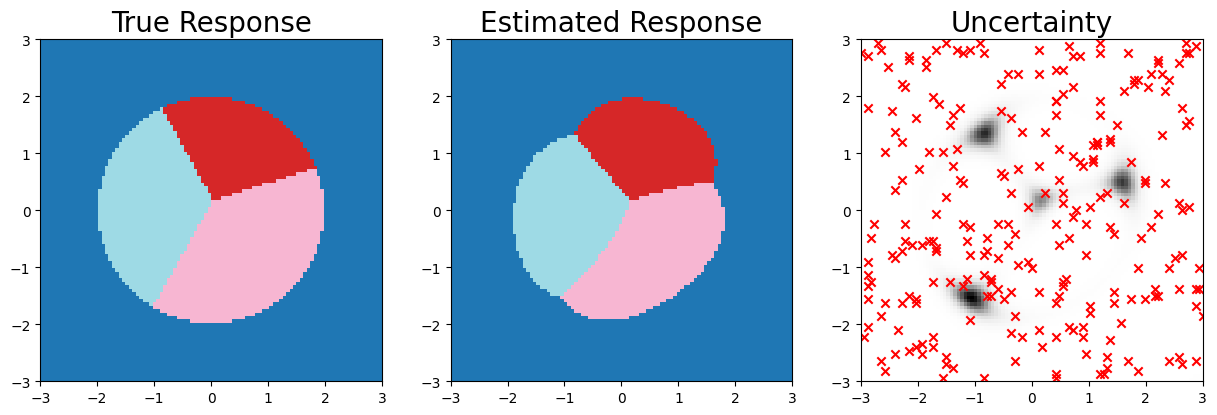

In [17]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

fig, ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].imshow(test_labels.numpy(), cmap=cmap, origin='lower', extent=[-3,3,-3,3])
ax[0].set_title('True Response', fontsize=20)

prediction = pred_means.max(0)[1].reshape((test_grid_size,test_grid_size))
diff = test_labels.numpy() - pred_means.max(0)[1].reshape((test_grid_size,test_grid_size)).numpy()
ax[1].imshow(prediction, cmap=cmap, origin='lower', extent=[-3,3,-3,3])

ax[1].set_title('Estimated Response', fontsize=20)

from scipy.ndimage import convolve
# tot = np.ones((test_grid_size,test_grid_size))
# all_probs = probabilities.numpy().reshape((-1,test_grid_size,test_grid_size)) 
# convolved_prob = all_probs[0]
# convolved_prob /= np.sum(convolved_prob)
# for i, prob_i in enumerate(all_probs):
#     j = i+1
#     if j == len(all_probs):
#         break
#     next_prob = all_probs[j]
#     next_prob /= np.sum(next_prob)
#     convolved_prob = convolve(convolved_prob, next_prob, mode='constant', cval=0)

tot = probabilities[0].numpy().reshape((test_grid_size,test_grid_size)) 
tot /= np.sum(tot)
for probability in probabilities[1:]:
    p = probability.numpy().reshape((test_grid_size,test_grid_size))
    tot *= p/np.sum(p)
p_pdf = tot/np.sum(tot)
pred_stddev = test_dist.stddev
stddev_pdf = pred_stddev.sum(0).detach().numpy().reshape((test_grid_size,test_grid_size))
all_probs = pred_stddev.detach().numpy().reshape((-1, test_grid_size,test_grid_size))

# stddev_pdf -= stddev_pdf.min()
# stddev_pdf /= stddev_pdf.sum()
# tot = convolve(p_pdf, convolved_prob, mode='constant', cval=0)
tot = p_pdf + 3 * stddev_pdf
tot /= tot.sum()
ax[2].imshow(p_pdf, origin='lower', extent=[-3,3,-3,3], cmap='Greys')
ax[2].scatter(train_x[:,0], train_x[:,1], c='r', marker='x')
ax[2].set_title('Uncertainty', fontsize=20)
print(f"Error: {np.sum(np.clip(np.abs(diff),0,1))/test_grid_size**2:.2%}")


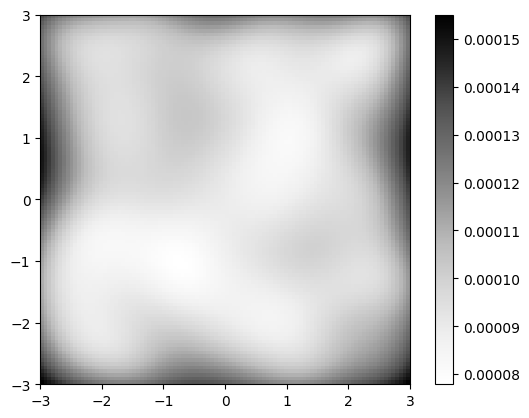

In [18]:
plt.imshow(tot, origin='lower', extent=[-3,3,-3,3], cmap='Greys')
plt.colorbar()

In [19]:
max_uncertainty_index = np.unravel_index(tot.argmax(), tot.shape)
max_uncertainty_index

(0, 0)

In [20]:
test_grid_size = 100
test_d1 = np.linspace(-3, 3, test_grid_size, dtype=np.float32)
test_d2 = np.linspace(-3, 3, test_grid_size, dtype=np.float32)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)), dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_y = test_labels.view(-1)

In [21]:
from predictor import fit, choose_next_position
from scipy.interpolate import griddata
measured_positions = [
    [-2.75,-2.75],
    [-2.75,2.75],
    [2.75,-2.75],
    [2.75,2.75],
    [-3,-3],
    [-3,3],
    [3,-3],
    [3,3],
]
measured_positions += np.random.uniform(-3,3,(2,2)).tolist()
# measured_positions = [[-3,-3]]
# measured_positions = np.random.uniform(-3,3,(1,2)).tolist()
measured_labels = [find_label(x,y) for x,y in measured_positions]
errors = []
grid_size = 1000
grid_x = np.linspace(-3, 3, grid_size)
grid_y = np.linspace(-3, 3, grid_size)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)
grid_labels = genfn(grid_x, grid_y)
while len(measured_positions) < 100:
    num_test_points = int(len(grid_x)*len(grid_y)*0.01)
    test_d1 = np.random.uniform(-3, 3, num_test_points).astype(np.float32)
    test_d2 = np.random.uniform(-3, 3, num_test_points).astype(np.float32)
    test_d1 = np.round(test_d1/.06)*.06
    test_d2 = np.round(test_d2/.06)*.06
    test_x = torch.tensor([test_d1, test_d2]).T
    test_labels = torch.round(genfn(test_d1, test_d2))
    interpolated_test_labels = griddata(test_x.numpy(), test_labels.numpy(), (grid_x, grid_y), method='nearest')

    model = fit(
        torch.tensor(np.asarray(measured_positions, dtype=np.float32)),
        torch.tensor(np.asarray(measured_labels, dtype=int))
        )
    next_index, uncertainty_pdf = choose_next_position(model, test_x, measured_positions)

    new_x, new_y = test_x[next_index].numpy()
    measured_positions.append([new_x, new_y])
    measured_labels.append(find_label(new_x, new_y))
    if (not errors) or errors[-1] > 0.05:
        test_dist = model(test_x)
        pred_means = test_dist.loc
        pred_samples = test_dist.sample(torch.Size((256,))).exp()
        probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

        fig, ax = plt.subplots(1,3, figsize=(15, 5))

        ax[0].imshow(interpolated_test_labels, cmap=cmap, origin='lower', extent=[-3,3,-3,3], vmin=np.min(test_labels.numpy()), vmax=np.max(test_labels.numpy()))
        ax[0].scatter(np.asarray(measured_positions)[:,0], np.asarray(measured_positions)[:,1], c='k', marker='.')
        ax[0].set_title('True Response', fontsize=20)

        test_y_prediction = pred_means.max(0)[1]
        interpolated_predictions = griddata(test_x.numpy(), test_y_prediction.numpy(), (grid_x, grid_y), method='nearest')

        ax[1].imshow(interpolated_predictions, cmap=cmap, origin='lower', extent=[-3,3,-3,3], vmin=np.min(test_labels.numpy()), vmax=np.max(test_labels.numpy()))
        ax[1].scatter(np.asarray(measured_positions)[:,0], np.asarray(measured_positions)[:,1], c='k', marker='.')
        # ax[1].scatter(test_d1, test_d2, c = 'g', marker='.')
        ax[1].set_title('Estimated Response', fontsize=20)

        # tot = uncertainty_pdf.reshape((test_grid_size,test_grid_size))
        tot = griddata(test_x.numpy(), uncertainty_pdf, (grid_x, grid_y), method='nearest')
        ax[2].imshow(tot, origin='lower', extent=[-3,3,-3,3], cmap='Greys')
        ax[2].scatter(np.asarray(measured_positions)[:,0], np.asarray(measured_positions)[:,1], c='r', marker='.')
        ax[2].set_title('Uncertainty', fontsize=20)
        ax[2].scatter(new_x, new_y, c='g', marker='o')
        diff = interpolated_test_labels != interpolated_predictions
        err = np.sum(diff)/len(diff)**2
        errors.append(err)
        fig.suptitle(f'Error: {err:.2%}', fontsize=20)
        print(f'{len(measured_positions)}: Error: {err:.2%}', end='\r')
        fig.savefig('figures/{}.png'.format(len(measured_positions)))
        plt.close(fig)
    elif errors[-1] <= 0.05:
        break


/var/folders/0q/vg0y7m810cs6syqyx6_jgx_80000gn/T/ipykernel_33387/2499044768.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  test_x = torch.tensor([test_d1, test_d2]).T


In [ ]:
plt.plot(np.asarray(errors)*100)
plt.xlabel('Number of Measurements')
plt.ylabel('Error (%)')
plt.grid(which='both')
plt.xlim(0,40)
plt.ylim(0,50)
plt.savefig('error_grid_interpolation.png')


In [ ]:
test_dist = model(test_x)
pred_means = test_dist.loc
pred_samples = test_dist.sample(torch.Size((256,))).exp()
t_uncertainty = test_dist.stddev
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

In [ ]:
t_uncertainty.shape
t_img = t_uncertainty.mean(0).detach().numpy().reshape((test_grid_size,test_grid_size))
# t_img = t_uncertainty[0].detach().numpy().reshape((test_grid_size,test_grid_size))
t_img -= t_img.min()
t_img /= t_img.sum()

plt.imshow(t_img, origin='lower', extent=[-3,3,-3,3], cmap='Greys')
plt.colorbar()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].imshow(test_labels.numpy(), cmap=cmap, origin='lower', extent=[-3,3,-3,3])
ax[0].scatter(np.asarray(measured_positions)[:,0], np.asarray(measured_positions)[:,1], c='r', marker='x')
ax[0].set_title('True Response', fontsize=20)

prediction = pred_means.max(0)[1].reshape((test_grid_size,test_grid_size))
diff = test_labels.numpy() - pred_means.max(0)[1].reshape((test_grid_size,test_grid_size)).numpy()
ax[1].imshow(prediction, cmap=cmap, origin='lower', extent=[-3,3,-3,3])
ax[1].scatter(np.asarray(measured_positions)[:,0], np.asarray(measured_positions)[:,1], c='r', marker='x')
ax[1].set_title('Estimated Response', fontsize=20)

tot = uncertainty_pdf.reshape((test_grid_size,test_grid_size))
ax[2].imshow(t_img, origin='lower', extent=[-3,3,-3,3], cmap='Greys')
ax[2].scatter(np.asarray(measured_positions)[:,0], np.asarray(measured_positions)[:,1], c='r', marker='x')
ax[2].set_title('Uncertainty', fontsize=20)
ax[2].scatter(new_x, new_y, c='g', marker='o')
